In [1]:
import numpy as np
import pandas as pd
import math
import os
from scipy.signal import butter, sosfilt
from scipy import fftpack # FFT analysis
from scipy.stats import kurtosis
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.preprocessing import scale
from numpy import genfromtxt
from minisom import MiniSom 
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Product
from sklearn.model_selection import GridSearchCV, train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv("2023-04-17_11-30-08.csv")

In [3]:
data = pd.read_csv("stage2_label.csv", names=['Start', 'End', 'damageType', 'label'])

In [4]:
samplesLoc = data[['Start', 'End']].values

In [5]:
Boxlist= pd.read_csv("stage2_Boxlist.csv", names = ['start', 'end']) 

In [6]:
samplesBoxlist = Boxlist[['start', 'end']].values.astype(int)

In [7]:
data

,Start,End,damageType,label
0,88.89,91.57,NaN,0
1,257.27,269.70,large crack,1
2,272.29,279.34,NaN,0
3,299.09,304.96,NaN,0
4,307.38,315.93,large crack,1
...,...,...,...,...
126,5455.33,5460.46,NaN,0
127,5475.40,5480.30,NaN,0
128,5575.35,5579.61,Pothole,4
129,5580.37,5585.86,large crack,1


In [8]:
# Z_std, Z_P2Pmax, ZXY_msa, Y_cf, std_psdZ, energy_psdZ

def std(Array):
    return np.std(Array)


def P2Pmax(Array):
    maxi = np.max(Array)
    mini= np.min(Array)
    return maxi-mini

def sma(x,y,z):
    squared_values = x**2 + y**2 + z**2 # Square the acceleration values
    sma = np.sqrt(np.sum(squared_values))  # Sum and take the square root
    return sma


def energy(Array):
    return (np.sqrt(np.mean(Array**2)))**2


def cf(Array):
    peak_value = np.max(np.abs(Array))  # Calculate the peak value (absolute maximum)
    rms_value = np.sqrt(np.mean(Array**2))  # Calculate the RMS (Root Mean Square) value
    crest_factor = peak_value / rms_value  # Calculate the Crest Factor
    return crest_factor

def absmean(Array):
    absM = np.mean(abs(Array))
    return absM

In [9]:
def fft(Array):
    n = len(Array)
    f_hat = np.fft.fft(Array, n)
    dt = 1/100
    PSD = (f_hat * np.conj(f_hat) / n).real
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')
    return PSD[L], freq[L]

def butter_lowpass_filter1(data, lowcut, fs, order):
    sos = butter(order, lowcut,'low', False, 'sos', fs)
    filtered = sosfilt(sos, data)
    return filtered
def butter_highpass_filter1(data, highcut, fs, order):
    sos = butter(order, highcut,'high', False, 'sos', fs)
    filtered = sosfilt(sos, data)
    return filtered

In [10]:
# x: direction of horrizental, y: direction of vehicle moving
FilteredX = butter_highpass_filter1(df["x"].to_numpy(), 3, 100, 4)
FilteredX = butter_lowpass_filter1(FilteredX, 19, 100, 4)
df["x"]= FilteredX

FilteredY = butter_highpass_filter1(df["y"].to_numpy(), 3, 100, 4)
FilteredY = butter_lowpass_filter1(FilteredY, 19, 100, 4)
df["y"]= FilteredY

FilteredZ = butter_highpass_filter1(df["z"].to_numpy(), 3, 100, 4)
FilteredZ = butter_lowpass_filter1(FilteredZ, 19, 100, 4)
df["z"]= FilteredZ

psd_z, freq_z = fft(FilteredZ)
psd_x, freq_x = fft(FilteredX)
psd_y, freq_y = fft(FilteredY)

# df['psd_x'] = psd_x
# df['psd_y'] = psd_y
# df['psd_z'] = psd_z


In [11]:
vibDataX = df[['x']].values
samplesX = [vibDataX[start:end + 1] for start, end in samplesBoxlist]

vibDataY = df[['y']].values
samplesY = [vibDataY[start:end + 1] for start, end in samplesBoxlist]

vibDataZ = df[['z']].values
samplesZ = [vibDataZ[start:end + 1] for start, end in samplesBoxlist]

In [12]:
length = samplesLoc[:,1]-samplesLoc[:,0]

In [13]:
bumpPara = np.zeros(len(samplesZ))
for icount, ivalue in enumerate(samplesZ):
    for point in ivalue:
        if abs(point)>1.8:
            if point<0:
                bumpPara[icount] = -1
            else:
                bumpPara[icount] = 1
            break

In [14]:
bumpPara

array([ 0.,  0.,  0.,  0., -1.,  1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1., -1.,  0., -1., -1.,  0.,
       -1.,  0., -1.,  1.,  1., -1.,  0.,  1.,  0.,  0.,  1., -1.,  0.,
        1., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1., -1.,  1.,  0.,  0.,  1., -1.,  0.,
        0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  0.,  1., -1.,  0.,  0.,
       -1., -1., -1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0., -1., -1.,
        0.])

In [15]:
features = np.array([])
for count, (i, j ,k) in enumerate(zip(samplesX, samplesY, samplesZ)):
    features = np.concatenate([features, np.array([std(k),P2Pmax(k),absmean(k), sma(i,j,k), P2Pmax(k)/length[count], length[count], bumpPara[count]])])
features = features.reshape(-1,7)

In [16]:
P2Pmax(samplesZ[1])/length[1]

0.26194341695517265

In [17]:
# features = np.hstack((features,length.reshape(-1, 1),bumpPara.reshape(-1, 1)))

feature_names = ['stdZ', 'P2PmaxZ', 'absmeanZ', 'SMA', 'slend ratio','length', 'bumppara']

In [18]:
y = data.label.to_numpy()

In [19]:
y[y==3]=1
# y[y==4]=1
# y[y==2]=1

In [20]:
y

array([0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 1, 1, 0, 2,
       0, 2, 2, 1, 1, 0, 0, 0, 0, 4, 4, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 4, 4,
       0, 1, 0, 2, 4, 0, 0, 4, 1, 4, 0, 0, 1, 2, 0, 0, 0, 0, 4, 1, 0],
      dtype=int64)

In [21]:
np.sum(y==4)

11

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=22, shuffle=False)

In [34]:
from sklearn.ensemble import RandomForestClassifier # randomForest
from sklearn.metrics import classification_report, confusion_matrix
model = RandomForestClassifier(random_state=11, max_depth=5, n_estimators=60)#,class_weight='balanced_subsample') # Random state for reproducibility (same results every time)
# classifier training
fit = model.fit(X_train, y_train)

In [35]:
y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [36]:
def printClassResults(train, train_predicted, types):
    print("----",types, " -------\n")
    print(classification_report(train, train_predicted))
    print(confusion_matrix(train, train_predicted))


In [37]:
print("----TRAIN RESULTS -------\n")
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

print("\n\n----TEST RESULTS -------\n")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

----TRAIN RESULTS -------

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        49
           1       0.93      0.96      0.94        26
           2       0.91      0.91      0.91        11
           4       1.00      0.80      0.89         5

    accuracy                           0.96        91
   macro avg       0.95      0.91      0.93        91
weighted avg       0.96      0.96      0.96        91

[[48  1  0  0]
 [ 1 25  0  0]
 [ 0  1 10  0]
 [ 0  0  1  4]]


----TEST RESULTS -------

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.82      0.82      0.82        11
           2       1.00      1.00      1.00         5
           4       0.80      0.67      0.73         6

    accuracy                           0.88        40
   macro avg       0.88      0.86      0.87        40
weighted avg       0.87      0.88      0.87        40

[[17  0  0  1]

In [38]:
import pickle
with open('s2model.pkl','wb') as f:
    pickle.dump(model,f)

In [39]:
with open('s2model.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [40]:
y_predict = model2.predict(features)

In [32]:
print("\n\n----TEST RESULTS -------\n")
print(classification_report(y, y_predict))
print(confusion_matrix(y, y_predict))




----TEST RESULTS -------

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        67
           1       0.89      0.92      0.91        37
           2       0.94      0.94      0.94        16
           4       0.89      0.73      0.80        11

    accuracy                           0.93       131
   macro avg       0.92      0.89      0.90       131
weighted avg       0.93      0.93      0.93       131

[[65  1  0  1]
 [ 3 34  0  0]
 [ 0  1 15  0]
 [ 0  2  1  8]]


In [27]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

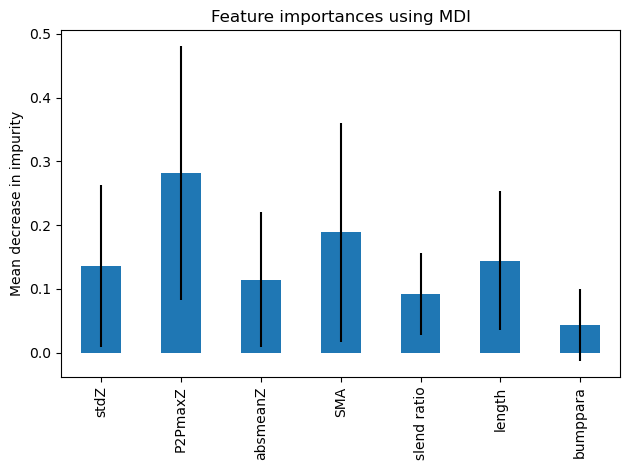

In [28]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [29]:
##### default length scale range : 0 - 1e5
##### 

In [41]:
from sklearn.mixture import GaussianMixture

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X_train, y_train)
kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0, 1.0,1.0,1.0,1.0,1.0,1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer = 6, ).fit(X_train, y_train)

titles = ["Isotropic RBF", "Anisotropic RBF"]

for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    
    Z = clf.predict_proba(X_train)
    M = clf.predict(X_train)

    printClassResults(y_train, M, str(i) + 'Train')
    
    Z = clf.predict_proba(X_test)
    M = clf.predict(X_test)
    printClassResults(y_test, M, str(i) + 'Test')

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

---- 0Train  -------

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        49
           1       0.61      0.88      0.72        26
           2       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         5

    accuracy                           0.78        91
   macro avg       0.38      0.47      0.41        91
weighted avg       0.66      0.78      0.71        91

[[48  1  0  0]
 [ 3 23  0  0]
 [ 1 10  0  0]
 [ 1  4  0  0]]
---- 0Test  -------

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.42      0.73      0.53        11
           2       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         6

    accuracy                           0.65        40
   macro avg       0.32      0.43      0.36        40
weighted avg       0.50      0.65      0.56        40

[[18  0  0  0]
 [ 3  8  0 

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

In [42]:
import pickle
with open('s2model.pkl','wb') as f:
    pickle.dump(gpc_rbf_anisotropic,f)

In [43]:
with open('s2model.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [45]:
model2.kernel_.kernels

[11.7**2 * RBF(length_scale=[1e+05, 1.54, 1.2, 1e+05, 1.86, 1e+05, 1e+05]),
 4.42**2 * RBF(length_scale=[7.99e+03, 0.895, 0.278, 1.93e+04, 1.14, 1e+05, 1.06]),
 6.36**2 * RBF(length_scale=[5.21e+03, 1e+05, 1e+05, 1e+05, 1e+05, 14, 0.107]),
 6.75**2 * RBF(length_scale=[1e+05, 2.74, 0.956, 1e+05, 1.41, 1e+05, 1.69e+04])]

In [31]:
gpc_rbf_anisotropic.kernel_.kernels

[11.7**2 * RBF(length_scale=[7.1e+03, 1.54, 1.2, 1e+05, 1.86, 1e+05, 1e+05]),
 4.42**2 * RBF(length_scale=[7.99e+03, 0.895, 0.278, 1.93e+04, 1.14, 1e+05, 1.06]),
 6.1**2 * RBF(length_scale=[1e+05, 4.48e+03, 1e+05, 9.99e+04, 1e+05, 14, 0.509]),
 6.75**2 * RBF(length_scale=[6.17e+04, 2.74, 0.956, 9.51e+04, 1.41, 9.67e+04, 1e+05])]

In [32]:
X_test.shape

(40, 7)

In [33]:
gpc_rbf_anisotropic.predict_proba(X_test)

array([[0.069105  , 0.86900293, 0.05109154, 0.01080053],
       [0.66178985, 0.30677821, 0.01990572, 0.01152622],
       [0.79961133, 0.16628149, 0.02160608, 0.01250111],
       [0.56777796, 0.38239054, 0.03747973, 0.01235178],
       [0.3276138 , 0.5920534 , 0.02364725, 0.05668555],
       [0.17674828, 0.21154748, 0.33639096, 0.27531328],
       [0.02298962, 0.70683066, 0.12269121, 0.14748851],
       [0.11456062, 0.10880918, 0.42120637, 0.35542384],
       [0.67721373, 0.29088185, 0.02086465, 0.01103977],
       [0.16652067, 0.78021798, 0.04293512, 0.01032623],
       [0.17430682, 0.23443481, 0.42030434, 0.17095403],
       [0.24402602, 0.36374136, 0.12058291, 0.27164971],
       [0.92464199, 0.02711311, 0.02650152, 0.02174338],
       [0.49604629, 0.47444025, 0.02067932, 0.00883414],
       [0.92681923, 0.01721301, 0.02914495, 0.02682282],
       [0.79815887, 0.16898747, 0.02093694, 0.01191672],
       [0.80657795, 0.15944666, 0.02135322, 0.01262218],
       [0.09503184, 0.2933982 ,

In [34]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

kernel =  C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Create a GaussianProcessClassifier with the custom kernel
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)

# Define the hyperparameter grid for the RBF kernel
classifier = OneVsRestClassifier(gpc_rbf_anisotropic)

# Set up k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=504)

# Perform k-fold cross-validation and get decision function scores

cv_scores = cross_val_score(classifier, features, y, cv=kf, scoring='accuracy')  # Corrected 'acuracy' to 'accuracy'

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f'Fold {i}: Accuracy = {score:.4f}')

# Print the mean and standard deviation of the cross-validation scores
print(f'\nMean Accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard Deviation: {np.std(cv_scores):.4f}')

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

Fold 1: Accuracy = 0.8889
Fold 2: Accuracy = 0.8077
Fold 3: Accuracy = 0.9615
Fold 4: Accuracy = 0.8077
Fold 5: Accuracy = 0.8077

Mean Accuracy: 0.8547
Standard Deviation: 0.0620


C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

In [46]:
kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0, 1.0,1.0,1.0,1.0,1.0,1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer = 6, ).fit(X_train, y_train)

Z = gpc_rbf_anisotropic.predict_proba(X_train)
M = gpc_rbf_anisotropic.predict(X_train)

printClassResults(y_train, M,  'Train')

Z = gpc_rbf_anisotropic.predict_proba(X_test)
M = gpc_rbf_anisotropic.predict(X_test)
printClassResults(y_test, M, 'Test')

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

---- Train  -------

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        49
           1       0.92      0.88      0.90        26
           2       1.00      0.82      0.90        11
           4       0.80      0.80      0.80         5

    accuracy                           0.92        91
   macro avg       0.91      0.87      0.89        91
weighted avg       0.92      0.92      0.92        91

[[48  1  0  0]
 [ 3 23  0  0]
 [ 0  1  9  1]
 [ 1  0  0  4]]
---- Test  -------

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.80      0.73      0.76        11
           2       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         6

    accuracy                           0.88        40
   macro avg       0.91      0.90      0.91        40
weighted avg       0.87      0.88      0.87        40

[[16  2  0  0]
 [ 3  8  0  0

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [51]:
print(Z)
print(M+1)
print(y_test+1)

[[0.06910507 0.86900377 0.05109127 0.01079989]
 [0.66179026 0.30677841 0.01990587 0.01152546]
 [0.79961161 0.16628155 0.02160624 0.0125006 ]
 [0.56777841 0.38239084 0.03747979 0.01235096]
 [0.32761353 0.59205292 0.02364738 0.05668616]
 [0.17674827 0.21154747 0.33638862 0.27531564]
 [0.0229895  0.70682681 0.12269051 0.14749318]
 [0.1145608  0.10880935 0.42120501 0.35542484]
 [0.67721405 0.29088199 0.02086481 0.01103915]
 [0.16652082 0.78021866 0.04293506 0.01032546]
 [0.17430727 0.23443542 0.4203022  0.17095511]
 [0.24402614 0.36374154 0.12058551 0.27164681]
 [0.92464321 0.02711315 0.02650168 0.02174196]
 [0.49604662 0.47444057 0.0206795  0.00883331]
 [0.92682103 0.01721304 0.02914511 0.02682081]
 [0.7981592  0.16898754 0.0209371  0.01191615]
 [0.8065782  0.15944671 0.02135338 0.01262172]
 [0.09503189 0.29339836 0.12741803 0.48415171]
 [0.15821084 0.26052433 0.09710872 0.4841561 ]
 [0.68943948 0.24315842 0.02158605 0.04581606]
 [0.0244071  0.69395436 0.20838081 0.07325773]
 [0.7734026  

In [36]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 6 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\kzhao\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:

In [37]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(40, 4)

In [38]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(4):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 4

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


In [39]:
target_names = ['Normal road', 'Large cracks', 'Road bumps', 'Potholes']

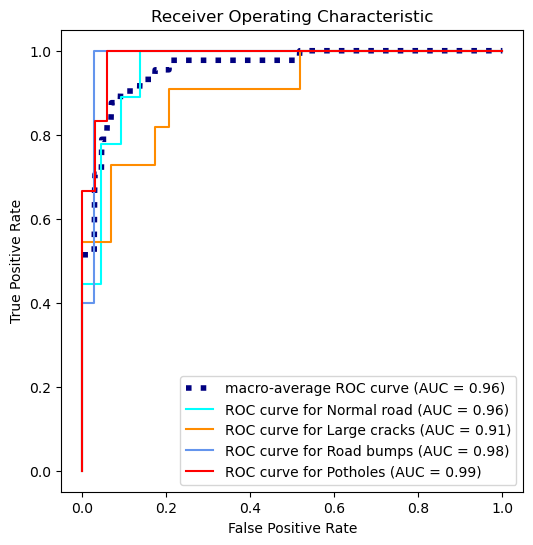

In [40]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()
# fig.savefig('ROC.svg', format='svg',dpi=300, bbox_inches='tight',transparent=True, pad_inches=0.1)
plt.close()

In [41]:
gpc_rbf_anisotropic.kernel_.kernels

[11.7**2 * RBF(length_scale=[7.1e+03, 1.54, 1.2, 1e+05, 1.86, 1e+05, 1e+05]),
 4.42**2 * RBF(length_scale=[1e+05, 0.895, 0.278, 1e+05, 1.14, 3.82e+04, 1.06]),
 6.1**2 * RBF(length_scale=[1e+05, 1e+05, 4.28e+03, 9.97e+04, 1e+05, 14, 0.509]),
 6.75**2 * RBF(length_scale=[1e+05, 2.74, 0.956, 1.56e+03, 1.41, 2.8e+03, 1e+05])]

In [44]:
gpc_rbf_anisotropic.predict_proba(X_test)

array([[0.06910483, 0.86899665, 0.05109743, 0.01080109],
       [0.66178981, 0.3067736 , 0.01990979, 0.0115268 ],
       [0.79960519, 0.1662841 , 0.02160961, 0.0125011 ],
       [0.56777241, 0.38239123, 0.03748472, 0.01235164],
       [0.32761526, 0.59204623, 0.02365231, 0.0566862 ],
       [0.17674649, 0.2115441 , 0.336396  , 0.27531341],
       [0.02298963, 0.7068325 , 0.12269129, 0.14748659],
       [0.11456074, 0.10880635, 0.42121696, 0.35541594],
       [0.67720954, 0.29088238, 0.02086815, 0.01103993],
       [0.16652034, 0.78021199, 0.04294071, 0.01032697],
       [0.17430425, 0.23443001, 0.42030662, 0.17095913],
       [0.24402351, 0.36373638, 0.12058094, 0.27165917],
       [0.9246352 , 0.02711352, 0.02650728, 0.02174401],
       [0.49604566, 0.4744371 , 0.02068281, 0.00883444],
       [0.92681244, 0.01721287, 0.02915152, 0.02682317],
       [0.79815297, 0.16898964, 0.02094052, 0.01191687],
       [0.80657187, 0.15944919, 0.02135675, 0.01262219],
       [0.09503224, 0.2934021 ,

In [43]:
meanFeatures = np.mean(features,axis=0)

In [45]:
y_test

array([1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 4, 4, 0, 1, 0,
       2, 4, 0, 0, 4, 1, 4, 0, 0, 1, 2, 0, 0, 0, 0, 4, 1, 0], dtype=int64)